In [48]:
from ipynb.fs.full.DSC680_CPJP_EDA import *

In [49]:
#For real-valued input data types, log always returns real output
cust_data_subset['Log_Unit_Price']=np.log(cust_data_subset['unit_price'])

In [50]:
cust_data_subset.head()

,transaction_dt,customer_id,age_int,product_subclass,product_id,pin_code_int,asset,amount,sales_price,year,month,week,day,unit_price,Log_Unit_Price
753166,2000-11-01,02101750,3,130315,4714981010038,5,28,1,24,2000,11,44,1,24.0,3.178
787527,2000-11-01,02144511,1,110401,4710088410382,5,44,1,55,2000,11,44,1,55.0,4.007
787526,2000-11-01,02144511,1,100312,37000445111,5,38,1,47,2000,11,44,1,47.0,3.850
787525,2000-11-01,02144511,1,100205,4711372660094,5,58,1,76,2000,11,44,1,76.0,4.331
787524,2000-11-01,02144511,1,110401,4710008290032,5,46,1,57,2000,11,44,1,57.0,4.043


In [51]:
temp_df=cust_data_subset[['transaction_dt','customer_id','amount','unit_price','Log_Unit_Price']]
temp_df['total_sum']=temp_df['amount']*temp_df['unit_price']
rmf_df=temp_df.groupby(['customer_id','transaction_dt']).sum()
# initializing frequency,recency,monetary
rmf_df['frequency']=1
rmf_df['recency']=1
rmf_df['monetary']=1
rmf_df.head(5)

amount  unit_price  Log_Unit_Price  total_sum  frequency  recency  monetary
customer_id transaction_dt                                                                             
00001069    2000-11-13         2      187.000        9.074        187.0        1         1         1   
            2001-01-21         3      971.000       17.193        971.0        1         1         1   
            2001-02-03         9      283.000       19.490        496.0        1         1         1   
            2001-02-10         2      145.000        4.977        290.0        1         1         1   
00001113    2000-11-12         5      144.833        7.544        420.0        1         1         1

In [52]:
#Identify lower transaction date
transaction_dt_min=cust_data.transaction_dt.min()

#function to calculate difference in days
def diff_days(start_day,end_day):  
    delta = start_day - end_day
    return delta.days

In [53]:
counter_idx=[0]
recency=[]
frequency=[]
monetary=[]
summer_mt=0
counter=0

for i in range(len(rmf_df.index)):
    customer_id=rmf_df.index[i][0]
    transaction_dt=rmf_df.index[i][1].date()
    counter_idx.append(customer_id)
    counter+=1
    summer_mt+=rmf_df.total_sum.values[i]
    if counter_idx[-2]!=customer_id:
        counter=1
        frequency.append(counter)
        start_date=transaction_dt_min.date()
        end_date=transaction_dt
        recency.append(diff_days(start_date,end_date))
        summer_mt=rmf_df.total_sum.values[i]
        monetary.append(summer_mt)
    else:
        start_date=rmf_df.index[i-1][1].date()
        end_date=transaction_dt
        recency.append(diff_days(start_date,end_date))
        frequency.append(counter)
        monetary.append(summer_mt)
        
rmf_df['recency']=recency
rmf_df['monetary']=monetary  
rmf_df['frequency']=frequency
rmf_df_reset=rmf_df.reset_index()
rmf_df_reset.head(10)

,customer_id,transaction_dt,amount,unit_price,Log_Unit_Price,total_sum,frequency,recency,monetary
0,00001069,2000-11-13,2,187.000,9.074,187.0,1,-12,187.0
1,00001069,2001-01-21,3,971.000,17.193,971.0,2,-69,1158.0
2,00001069,2001-02-03,9,283.000,19.490,496.0,3,-13,1654.0
3,00001069,2001-02-10,2,145.000,4.977,290.0,4,-7,1944.0
4,00001113,2000-11-12,5,144.833,7.544,420.0,1,-11,420.0
5,00001113,2000-11-26,3,558.000,15.488,558.0,2,-14,978.0
6,00001113,2000-11-27,6,624.000,26.221,624.0,3,-1,1602.0
7,00001113,2001-01-06,9,544.000,28.356,628.0,4,-40,2230.0
8,00001250,2001-02-04,5,685.000,19.810,734.0,1,-95,734.0
9,00001250,2001-02-10,13,792.000,38.402,849.0,2,-6,1583.0


In [54]:
rmf_df_reset['year'],rmf_df_reset['month'],rmf_df_reset['week'],rmf_df_reset['day']=get_date_int(rmf_df_reset,'transaction_dt')

In [55]:
#This dictionary codes the weeks from week of the year (52 weeks) to the week from entry into the dataset to end
wk_dict_int = {44:0, 45:1, 46:2, 47:3, 48:4, \
        49:5, 50:6, 51:7, 52:8, 1:9, 2:10 , 3:11 , 4:12, 5:13 ,6:14 ,7:15,8:16,9:17}


In [56]:
rmf_df_reset=rmf_df_reset.sort_values(by=['transaction_dt','customer_id']).reset_index(drop=True)
rmf_df_reset['week_number'] = rmf_df_reset['week'].apply(lambda x: wk_dict_int[x])
rmf_df_reset=rmf_df_reset.drop('week',axis=1)
rmf_df_reset=rmf_df_reset.sort_values(by=['customer_id','week_number'])
rmf_df_reset['age_int'] = rmf_df_reset['customer_id'].apply(lambda x: age_map[x])
rmf_df_reset['pin_code_int'] = rmf_df_reset['customer_id'].apply(lambda x: pin_map[x])

In [57]:
final_rmf_df=rmf_df_reset[['transaction_dt','customer_id','week_number','amount','total_sum','frequency','recency','monetary','age_int','pin_code_int','unit_price','Log_Unit_Price']]
comp_fr=(final_rmf_df['frequency']>1)
print('Average Frequency:',round(final_rmf_df[comp_fr].frequency.mean()))
print('Average Week Number:',round(final_rmf_df[comp_fr].week_number.mean()))
round(final_rmf_df[comp_fr].week_number.value_counts())

Average Frequency: 7
Average Week Number: 10


16    8084
11    7827
15    6363
14    6339
13    6024
6     5981
12    5677
10    5601
5     5183
4     5135
8     5108
3     4885
9     3526
2     3463
1     3167
17    2834
7     1329
0      786
Name: week_number, dtype: int64

observation: We can see weeks 16 and 11 have the most transactions; also most customers have made around 6 purchases in the 4 month period of time

Next steps: I will be restricting the independant features to values prior to week 16 and the dependant features to weeks 16 or 17. The intention is to use the transactions in the first 15 weeks to predict transactions within the last two weeks.

In [58]:
final_rmf_df.head(5)

,transaction_dt,customer_id,week_number,amount,total_sum,frequency,recency,monetary,age_int,pin_code_int,unit_price,Log_Unit_Price
13176,2000-11-13,00001069,2,2,187.0,1,-12,187.0,11,5,187.000,9.074
77139,2001-01-21,00001069,11,3,971.0,2,-69,1158.0,11,5,971.000,17.193
90033,2001-02-03,00001069,13,9,496.0,3,-13,1654.0,11,5,283.000,19.490
97470,2001-02-10,00001069,14,2,290.0,4,-7,1944.0,11,5,145.000,4.977
11523,2000-11-12,00001113,1,5,420.0,1,-11,420.0,11,6,144.833,7.544


In [59]:
#Fetch final week data based on the observation that this week contains more transactions
feature_df=((final_rmf_df['week_number']<=15) & (final_rmf_df['frequency']>1)) 
X_set=final_rmf_df[feature_df]
#Fetch previous transactions for dependent features
feature_df=((final_rmf_df['week_number']==16) | (final_rmf_df['week_number']==17) & (final_rmf_df['frequency']>1))
y_set=final_rmf_df[feature_df]

In [60]:
#for regression the independant values need to have a matching customer ID in the dependent values. 
y_id_list=sorted(list(y_set.customer_id.unique()))

In [61]:
X_set=X_set.loc[X_set['customer_id'].isin(y_id_list)]#have to be represented in final week
X_set=X_set[X_set.groupby('customer_id')['transaction_dt'].rank() == 1].reset_index()
X_set.head(5)
ind=X_set.index
num_rows=len(ind)
print(num_rows)
print(X_set.head(5))

6670
   index transaction_dt customer_id  week_number  amount  total_sum  frequency  recency  monetary  age_int  pin_code_int  unit_price  Log_Unit_Price
0  62438   2001-01-07     00005241        9         19      931.0        2       -22      1256.0      4           6          616.0        37.835    
1  24296   2000-11-25     00006668        3         11      873.0        2       -14      1305.0      4           5          835.0        33.562    
2   5116   2000-11-06     00010801        1          5      574.0        2        -2       663.0      4           5          574.0        23.360    
3  20945   2000-11-22     00011235        3          6      425.0        2        -8      1331.0     11           6          425.0        24.638    
4  42565   2000-12-11     00011914        6         13     1266.0        2        -8      1723.0      4           1         1113.0        44.232    


In [62]:
X_set=X_set.sort_values(by=['customer_id'])#sort by id
X_set=X_set.reset_index(drop=True)
print('number of unique customer ids:',len(set(list(X_set.customer_id))),'\nlength of the dataset:',len(X_set))
X_set.head()

number of unique customer ids: 6670 
length of the dataset: 6670


,index,transaction_dt,customer_id,week_number,amount,total_sum,frequency,recency,monetary,age_int,pin_code_int,unit_price,Log_Unit_Price
0,62438,2001-01-07,00005241,9,19,931.0,2,-22,1256.0,4,6,616.0,37.835
1,24296,2000-11-25,00006668,3,11,873.0,2,-14,1305.0,4,5,835.0,33.562
2,5116,2000-11-06,00010801,1,5,574.0,2,-2,663.0,4,5,574.0,23.360
3,20945,2000-11-22,00011235,3,6,425.0,2,-8,1331.0,11,6,425.0,24.638
4,42565,2000-12-11,00011914,6,13,1266.0,2,-8,1723.0,4,1,1113.0,44.232


In [63]:
X_set_list=sorted(list(X_set.customer_id.unique()))#get list of unique ids from those represented in the last month
y_set=y_set.loc[y_set['customer_id'].isin(X_set_list)]#return only individuals who made a purchase in the prior month

In [64]:
y_set=y_set[y_set.groupby('customer_id')['transaction_dt'].rank() == 1].reset_index()
y_set=y_set.sort_values(by=['customer_id'])
y_set=y_set.reset_index(drop=True)
print('number of unique customer ids:',len(set(list(y_set.customer_id))),'\nlength of the dataset:',len(y_set))
y_set.head()

number of unique customer ids: 6670 
length of the dataset: 6670


,index,transaction_dt,customer_id,week_number,amount,total_sum,frequency,recency,monetary,age_int,pin_code_int,unit_price,Log_Unit_Price
0,107300,2001-02-19,00005241,16,6,315.0,4,-34,3396.0,4,6,267.0,19.792
1,111018,2001-02-22,00006668,16,2,193.0,10,-5,5099.0,4,5,193.0,9.102
2,107301,2001-02-19,00010801,16,4,161.0,15,-7,7045.0,4,5,161.0,14.655
3,117403,2001-02-27,00011235,17,7,1157.0,5,-10,4209.0,11,6,972.0,29.231
4,118286,2001-02-28,00011914,17,4,276.0,5,-53,2616.0,4,1,138.0,8.380


In [65]:
X_set_df=X_set[['customer_id', 'week_number', 'amount', 'total_sum', 'age_int','pin_code_int','unit_price','Log_Unit_Price','frequency', 'recency', 'monetary']]#reduce Xset
y_set_df=y_set[['customer_id','frequency','recency','monetary']]#reduce yset

In [66]:
X_set_df.head(3)

,customer_id,week_number,amount,total_sum,age_int,pin_code_int,unit_price,Log_Unit_Price,frequency,recency,monetary
0,00005241,9,19,931.0,4,6,616.0,37.835,2,-22,1256.0
1,00006668,3,11,873.0,4,5,835.0,33.562,2,-14,1305.0
2,00010801,1,5,574.0,4,5,574.0,23.360,2,-2,663.0


In [67]:
# Splits the records into two parts part 1 contains Customer ID all other fields in part 2
def return_pair(df,indexer=0):
    data=df.iloc[indexer]
    x=[]
    part1=list(map(int,list(data.iloc[0])))
    part2=list(data.iloc[1:])
    x.extend(part1)
    x.extend(part2)
    x=np.array(x)
    return x
X_set=np.array([return_pair(X_set_df,i) for i in range(0,len(X_set_df))])

In [68]:
y_set=np.array([return_pair(y_set_df,i) for i in range(0,len(y_set_df))])

In [69]:
n_orig_size=len(X_set)
n_train_percent = round(n_orig_size*.2)
print('Original size:',n_orig_size,'\n20 Percent of size:',n_train_percent)

Original size: 6670 
20 Percent of size: 1334


In [70]:
train_X=X_set[n_train_percent:,:]
train_y=y_set[n_train_percent:,:]
test_X=X_set[:n_train_percent, :]
test_y=y_set[:n_train_percent, :]

In [71]:
train_X.shape,test_X.shape

((5336, 18), (1334, 18))

In [72]:
train_y.shape,test_y.shape

((5336, 11), (1334, 11))

In [73]:
from sklearn.preprocessing import MinMaxScaler
scaler_y = MinMaxScaler(feature_range=(0, 1))
train_y = scaler_y.fit_transform(train_y)
test_y = scaler_y.fit_transform(test_y)

In [74]:
scaler_x = MinMaxScaler(feature_range=(0, 1))
rescaled_x_train = scaler_x.fit_transform(train_X)
rescaled_x_test = scaler_x.fit_transform(test_X)

In [75]:
# reshape input to be 3D [samples, timesteps, features]
train_X = rescaled_x_train.reshape((rescaled_x_train.shape[0], 1, rescaled_x_train.shape[1]))
test_X = rescaled_x_test.reshape((rescaled_x_test.shape[0], 1, rescaled_x_test.shape[1]))
print('train_X',train_X.shape,'\ntrain_y', train_y.shape,'\ntest_X', test_X.shape,'\ntest_y', test_y.shape)

train_X (5336, 1, 18) 
train_y (5336, 11) 
test_X (1334, 1, 18) 
test_y (1334, 11)


In [76]:
from keras.models import Sequential
from keras.layers import SimpleRNN
from keras.layers import Input, Dense, Dropout, LSTM
from keras import regularizers
epochs = 1000
learning_rate = 0.001
model = Sequential()
model.add(SimpleRNN(11,activation='relu',input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(250,kernel_initializer='random_uniform', activity_regularizer=regularizers.l1(0.0001)))
model.add(Dense(11))
model.compile(loss='mse', optimizer='adam', metrics=['mae', 'acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 11)                330       
                                                                 
 dense_2 (Dense)             (None, 250)               3000      
                                                                 
 dense_3 (Dense)             (None, 11)                2761      
                                                                 
Total params: 6,091
Trainable params: 6,091
Non-trainable params: 0
_________________________________________________________________


In [77]:
# fit network
RNN_classifier = model.fit(train_X, train_y, epochs=epochs, batch_size=120, validation_data=(test_X, test_y), validation_split=0.3, verbose=1, shuffle=True)


Epoch 1/1000
32/32 [==============================] - 1s 7ms/step - loss: 0.0946 - mae: 0.2163 - acc: 0.2889 - val_loss: 0.0842 - val_mae: 0.2102 - val_acc: 0.0000e+00
Epoch 2/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0441 - mae: 0.1501 - acc: 0.3226 - val_loss: 0.0558 - val_mae: 0.1696 - val_acc: 0.0256
Epoch 3/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0307 - mae: 0.1217 - acc: 0.4233 - val_loss: 0.0424 - val_mae: 0.1421 - val_acc: 0.1868
Epoch 4/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0215 - mae: 0.0984 - acc: 0.5028 - val_loss: 0.0318 - val_mae: 0.1198 - val_acc: 0.1643
Epoch 5/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0166 - mae: 0.0833 - acc: 0.5580 - val_loss: 0.0285 - val_mae: 0.1115 - val_acc: 0.1568
Epoch 6/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0137 - mae: 0.0729 - acc: 0.6099 - val_loss: 0.0246 - val_mae: 0.1021 - val_acc: 0.1868
Epoch 7/1000

Epoch 51/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0046 - mae: 0.0241 - acc: 0.7191 - val_loss: 0.0059 - val_mae: 0.0272 - val_acc: 0.7495
Epoch 52/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0045 - mae: 0.0234 - acc: 0.7250 - val_loss: 0.0058 - val_mae: 0.0277 - val_acc: 0.7814
Epoch 53/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0045 - mae: 0.0226 - acc: 0.7234 - val_loss: 0.0061 - val_mae: 0.0293 - val_acc: 0.7539
Epoch 54/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0046 - mae: 0.0245 - acc: 0.7157 - val_loss: 0.0058 - val_mae: 0.0269 - val_acc: 0.8001
Epoch 55/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0045 - mae: 0.0227 - acc: 0.7272 - val_loss: 0.0058 - val_mae: 0.0271 - val_acc: 0.7383
Epoch 56/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0044 - mae: 0.0223 - acc: 0.7280 - val_loss: 0.0060 - val_mae: 0.0261 - val_acc: 0.7776
Epoch 57/1

Epoch 101/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0042 - mae: 0.0224 - acc: 0.7175 - val_loss: 0.0055 - val_mae: 0.0276 - val_acc: 0.6215
Epoch 102/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0042 - mae: 0.0219 - acc: 0.7250 - val_loss: 0.0054 - val_mae: 0.0286 - val_acc: 0.6077
Epoch 103/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0042 - mae: 0.0228 - acc: 0.7173 - val_loss: 0.0054 - val_mae: 0.0247 - val_acc: 0.7676
Epoch 104/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0042 - mae: 0.0228 - acc: 0.7170 - val_loss: 0.0056 - val_mae: 0.0243 - val_acc: 0.7664
Epoch 105/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0042 - mae: 0.0225 - acc: 0.7301 - val_loss: 0.0054 - val_mae: 0.0277 - val_acc: 0.8170
Epoch 106/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0043 - mae: 0.0231 - acc: 0.7183 - val_loss: 0.0054 - val_mae: 0.0263 - val_acc: 0.8851
Epoc

32/32 [==============================] - 0s 2ms/step - loss: 0.0041 - mae: 0.0230 - acc: 0.7194 - val_loss: 0.0052 - val_mae: 0.0255 - val_acc: 0.7801
Epoch 151/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0040 - mae: 0.0223 - acc: 0.7242 - val_loss: 0.0052 - val_mae: 0.0264 - val_acc: 0.8788
Epoch 152/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0040 - mae: 0.0227 - acc: 0.7245 - val_loss: 0.0052 - val_mae: 0.0258 - val_acc: 0.6727
Epoch 153/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0040 - mae: 0.0226 - acc: 0.7151 - val_loss: 0.0052 - val_mae: 0.0245 - val_acc: 0.8401
Epoch 154/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.0040 - mae: 0.0233 - acc: 0.7266 - val_loss: 0.0052 - val_mae: 0.0263 - val_acc: 0.6027
Epoch 155/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0040 - mae: 0.0217 - acc: 0.7290 - val_loss: 0.0053 - val_mae: 0.0240 - val_acc: 0.6827
Epoch 156/1000
32/3

32/32 [==============================] - 0s 2ms/step - loss: 0.0040 - mae: 0.0240 - acc: 0.7242 - val_loss: 0.0052 - val_mae: 0.0277 - val_acc: 0.7858
Epoch 200/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0039 - mae: 0.0219 - acc: 0.7237 - val_loss: 0.0050 - val_mae: 0.0234 - val_acc: 0.7220
Epoch 201/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0039 - mae: 0.0220 - acc: 0.7232 - val_loss: 0.0050 - val_mae: 0.0237 - val_acc: 0.8595
Epoch 202/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0039 - mae: 0.0219 - acc: 0.7261 - val_loss: 0.0051 - val_mae: 0.0263 - val_acc: 0.6271
Epoch 203/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0039 - mae: 0.0227 - acc: 0.7170 - val_loss: 0.0051 - val_mae: 0.0258 - val_acc: 0.8851
Epoch 204/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0039 - mae: 0.0229 - acc: 0.7234 - val_loss: 0.0051 - val_mae: 0.0267 - val_acc: 0.6658
Epoch 205/1000
32/3

32/32 [==============================] - 0s 2ms/step - loss: 0.0039 - mae: 0.0227 - acc: 0.7205 - val_loss: 0.0051 - val_mae: 0.0244 - val_acc: 0.6483
Epoch 249/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0038 - mae: 0.0220 - acc: 0.7221 - val_loss: 0.0051 - val_mae: 0.0256 - val_acc: 0.6040
Epoch 250/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0038 - mae: 0.0224 - acc: 0.7261 - val_loss: 0.0050 - val_mae: 0.0247 - val_acc: 0.8126
Epoch 251/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0038 - mae: 0.0219 - acc: 0.7186 - val_loss: 0.0050 - val_mae: 0.0285 - val_acc: 0.6077
Epoch 252/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0039 - mae: 0.0227 - acc: 0.7213 - val_loss: 0.0050 - val_mae: 0.0246 - val_acc: 0.6365
Epoch 253/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0038 - mae: 0.0219 - acc: 0.7207 - val_loss: 0.0049 - val_mae: 0.0244 - val_acc: 0.7995
Epoch 254/1000
32/3

32/32 [==============================] - 0s 2ms/step - loss: 0.0038 - mae: 0.0221 - acc: 0.7258 - val_loss: 0.0049 - val_mae: 0.0232 - val_acc: 0.7358
Epoch 298/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0038 - mae: 0.0219 - acc: 0.7253 - val_loss: 0.0052 - val_mae: 0.0279 - val_acc: 0.6983
Epoch 299/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0038 - mae: 0.0235 - acc: 0.7181 - val_loss: 0.0052 - val_mae: 0.0246 - val_acc: 0.9507
Epoch 300/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0038 - mae: 0.0229 - acc: 0.7261 - val_loss: 0.0050 - val_mae: 0.0250 - val_acc: 0.9375
Epoch 301/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0038 - mae: 0.0234 - acc: 0.7207 - val_loss: 0.0050 - val_mae: 0.0262 - val_acc: 0.6421
Epoch 302/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0038 - mae: 0.0221 - acc: 0.7221 - val_loss: 0.0051 - val_mae: 0.0271 - val_acc: 0.6783
Epoch 303/1000
32/3

32/32 [==============================] - 0s 2ms/step - loss: 0.0037 - mae: 0.0218 - acc: 0.7282 - val_loss: 0.0049 - val_mae: 0.0250 - val_acc: 0.7183
Epoch 347/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0037 - mae: 0.0216 - acc: 0.7183 - val_loss: 0.0049 - val_mae: 0.0263 - val_acc: 0.9288
Epoch 348/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0037 - mae: 0.0223 - acc: 0.7189 - val_loss: 0.0049 - val_mae: 0.0269 - val_acc: 0.7901
Epoch 349/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0037 - mae: 0.0225 - acc: 0.7181 - val_loss: 0.0049 - val_mae: 0.0274 - val_acc: 0.6408
Epoch 350/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0037 - mae: 0.0227 - acc: 0.7197 - val_loss: 0.0050 - val_mae: 0.0255 - val_acc: 0.6015
Epoch 351/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0037 - mae: 0.0214 - acc: 0.7175 - val_loss: 0.0049 - val_mae: 0.0234 - val_acc: 0.6152
Epoch 352/1000
32/3

32/32 [==============================] - 0s 2ms/step - loss: 0.0037 - mae: 0.0228 - acc: 0.7178 - val_loss: 0.0049 - val_mae: 0.0249 - val_acc: 0.7633
Epoch 396/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0037 - mae: 0.0211 - acc: 0.7205 - val_loss: 0.0049 - val_mae: 0.0246 - val_acc: 0.8576
Epoch 397/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0037 - mae: 0.0214 - acc: 0.7216 - val_loss: 0.0048 - val_mae: 0.0253 - val_acc: 0.8176
Epoch 398/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0037 - mae: 0.0226 - acc: 0.7218 - val_loss: 0.0049 - val_mae: 0.0276 - val_acc: 0.9225
Epoch 399/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0037 - mae: 0.0220 - acc: 0.7194 - val_loss: 0.0049 - val_mae: 0.0267 - val_acc: 0.6365
Epoch 400/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0037 - mae: 0.0220 - acc: 0.7127 - val_loss: 0.0048 - val_mae: 0.0239 - val_acc: 0.7464
Epoch 401/1000
32/3

32/32 [==============================] - 0s 2ms/step - loss: 0.0037 - mae: 0.0217 - acc: 0.7197 - val_loss: 0.0048 - val_mae: 0.0269 - val_acc: 0.7052
Epoch 445/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0037 - mae: 0.0215 - acc: 0.7159 - val_loss: 0.0048 - val_mae: 0.0241 - val_acc: 0.7833
Epoch 446/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0037 - mae: 0.0214 - acc: 0.7221 - val_loss: 0.0048 - val_mae: 0.0259 - val_acc: 0.7933
Epoch 447/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0037 - mae: 0.0224 - acc: 0.7232 - val_loss: 0.0048 - val_mae: 0.0232 - val_acc: 0.7108
Epoch 448/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0037 - mae: 0.0216 - acc: 0.7181 - val_loss: 0.0048 - val_mae: 0.0247 - val_acc: 0.8957
Epoch 449/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0037 - mae: 0.0213 - acc: 0.7226 - val_loss: 0.0048 - val_mae: 0.0241 - val_acc: 0.7358
Epoch 450/1000
32/3

32/32 [==============================] - 0s 2ms/step - loss: 0.0037 - mae: 0.0216 - acc: 0.7167 - val_loss: 0.0048 - val_mae: 0.0245 - val_acc: 0.7158
Epoch 494/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0211 - acc: 0.7299 - val_loss: 0.0049 - val_mae: 0.0246 - val_acc: 0.9881
Epoch 495/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0212 - acc: 0.7162 - val_loss: 0.0049 - val_mae: 0.0231 - val_acc: 0.7083
Epoch 496/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0037 - mae: 0.0209 - acc: 0.7280 - val_loss: 0.0048 - val_mae: 0.0239 - val_acc: 0.7820
Epoch 497/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0037 - mae: 0.0214 - acc: 0.7237 - val_loss: 0.0049 - val_mae: 0.0285 - val_acc: 0.7196
Epoch 498/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0037 - mae: 0.0223 - acc: 0.7162 - val_loss: 0.0048 - val_mae: 0.0225 - val_acc: 0.7002
Epoch 499/1000
32/3

32/32 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0220 - acc: 0.7226 - val_loss: 0.0048 - val_mae: 0.0251 - val_acc: 0.9275
Epoch 543/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0218 - acc: 0.7224 - val_loss: 0.0049 - val_mae: 0.0252 - val_acc: 0.8170
Epoch 544/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0219 - acc: 0.7210 - val_loss: 0.0048 - val_mae: 0.0244 - val_acc: 0.8064
Epoch 545/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0213 - acc: 0.7205 - val_loss: 0.0049 - val_mae: 0.0301 - val_acc: 0.8264
Epoch 546/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0037 - mae: 0.0242 - acc: 0.7151 - val_loss: 0.0048 - val_mae: 0.0261 - val_acc: 0.7876
Epoch 547/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0211 - acc: 0.7183 - val_loss: 0.0048 - val_mae: 0.0257 - val_acc: 0.7708
Epoch 548/1000
32/3

32/32 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0211 - acc: 0.7154 - val_loss: 0.0049 - val_mae: 0.0248 - val_acc: 0.6989
Epoch 592/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0037 - mae: 0.0220 - acc: 0.7170 - val_loss: 0.0048 - val_mae: 0.0237 - val_acc: 0.7664
Epoch 593/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0212 - acc: 0.7226 - val_loss: 0.0048 - val_mae: 0.0239 - val_acc: 0.7589
Epoch 594/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0207 - acc: 0.7253 - val_loss: 0.0048 - val_mae: 0.0280 - val_acc: 0.7833
Epoch 595/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0037 - mae: 0.0226 - acc: 0.7106 - val_loss: 0.0048 - val_mae: 0.0274 - val_acc: 0.6446
Epoch 596/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0037 - mae: 0.0222 - acc: 0.7135 - val_loss: 0.0047 - val_mae: 0.0244 - val_acc: 0.8326
Epoch 597/1000
32/3

32/32 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0212 - acc: 0.7248 - val_loss: 0.0048 - val_mae: 0.0251 - val_acc: 0.7439
Epoch 641/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0210 - acc: 0.7218 - val_loss: 0.0049 - val_mae: 0.0227 - val_acc: 0.7783
Epoch 642/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0207 - acc: 0.7234 - val_loss: 0.0047 - val_mae: 0.0235 - val_acc: 0.8151
Epoch 643/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0216 - acc: 0.7216 - val_loss: 0.0048 - val_mae: 0.0232 - val_acc: 0.8819
Epoch 644/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0215 - acc: 0.7258 - val_loss: 0.0048 - val_mae: 0.0235 - val_acc: 0.8426
Epoch 645/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0211 - acc: 0.7269 - val_loss: 0.0047 - val_mae: 0.0234 - val_acc: 0.7601
Epoch 646/1000
32/3

32/32 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0210 - acc: 0.7224 - val_loss: 0.0048 - val_mae: 0.0226 - val_acc: 0.7520
Epoch 690/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0214 - acc: 0.7237 - val_loss: 0.0048 - val_mae: 0.0249 - val_acc: 0.7964
Epoch 691/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0212 - acc: 0.7151 - val_loss: 0.0047 - val_mae: 0.0233 - val_acc: 0.8557
Epoch 692/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0208 - acc: 0.7216 - val_loss: 0.0047 - val_mae: 0.0246 - val_acc: 0.7452
Epoch 693/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0212 - acc: 0.7221 - val_loss: 0.0047 - val_mae: 0.0257 - val_acc: 0.8364
Epoch 694/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0227 - acc: 0.7242 - val_loss: 0.0047 - val_mae: 0.0248 - val_acc: 0.7626
Epoch 695/1000
32/3

32/32 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0214 - acc: 0.7165 - val_loss: 0.0047 - val_mae: 0.0248 - val_acc: 0.7645
Epoch 739/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0218 - acc: 0.7159 - val_loss: 0.0047 - val_mae: 0.0263 - val_acc: 0.8944
Epoch 740/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0219 - acc: 0.7216 - val_loss: 0.0047 - val_mae: 0.0248 - val_acc: 0.9332
Epoch 741/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0211 - acc: 0.7175 - val_loss: 0.0048 - val_mae: 0.0245 - val_acc: 0.7739
Epoch 742/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0214 - acc: 0.7202 - val_loss: 0.0047 - val_mae: 0.0241 - val_acc: 0.7626
Epoch 743/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0207 - acc: 0.7178 - val_loss: 0.0047 - val_mae: 0.0241 - val_acc: 0.8195
Epoch 744/1000
32/3

32/32 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0215 - acc: 0.7178 - val_loss: 0.0047 - val_mae: 0.0235 - val_acc: 0.8701
Epoch 788/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0204 - acc: 0.7221 - val_loss: 0.0047 - val_mae: 0.0234 - val_acc: 0.7439
Epoch 789/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0206 - acc: 0.7253 - val_loss: 0.0047 - val_mae: 0.0233 - val_acc: 0.7808
Epoch 790/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0208 - acc: 0.7207 - val_loss: 0.0047 - val_mae: 0.0233 - val_acc: 0.6152
Epoch 791/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0205 - acc: 0.7229 - val_loss: 0.0047 - val_mae: 0.0233 - val_acc: 0.7202
Epoch 792/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0207 - acc: 0.7226 - val_loss: 0.0047 - val_mae: 0.0238 - val_acc: 0.6627
Epoch 793/1000
32/3

32/32 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0210 - acc: 0.7272 - val_loss: 0.0047 - val_mae: 0.0238 - val_acc: 0.6021
Epoch 837/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0213 - acc: 0.7237 - val_loss: 0.0047 - val_mae: 0.0249 - val_acc: 0.7046
Epoch 838/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0209 - acc: 0.7248 - val_loss: 0.0047 - val_mae: 0.0221 - val_acc: 0.8057
Epoch 839/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0204 - acc: 0.7253 - val_loss: 0.0047 - val_mae: 0.0255 - val_acc: 0.7670
Epoch 840/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0217 - acc: 0.7277 - val_loss: 0.0047 - val_mae: 0.0246 - val_acc: 0.9250
Epoch 841/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0217 - acc: 0.7221 - val_loss: 0.0046 - val_mae: 0.0224 - val_acc: 0.7864
Epoch 842/1000
32/3

32/32 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0210 - acc: 0.7197 - val_loss: 0.0047 - val_mae: 0.0234 - val_acc: 0.7845
Epoch 886/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0204 - acc: 0.7245 - val_loss: 0.0047 - val_mae: 0.0235 - val_acc: 0.7414
Epoch 887/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0201 - acc: 0.7181 - val_loss: 0.0047 - val_mae: 0.0253 - val_acc: 0.8607
Epoch 888/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0218 - acc: 0.7191 - val_loss: 0.0047 - val_mae: 0.0251 - val_acc: 0.7264
Epoch 889/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0220 - acc: 0.7135 - val_loss: 0.0047 - val_mae: 0.0226 - val_acc: 0.8189
Epoch 890/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0209 - acc: 0.7173 - val_loss: 0.0047 - val_mae: 0.0240 - val_acc: 0.7945
Epoch 891/1000
32/3

32/32 [==============================] - 0s 2ms/step - loss: 0.0035 - mae: 0.0209 - acc: 0.7229 - val_loss: 0.0047 - val_mae: 0.0235 - val_acc: 0.7308
Epoch 935/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0035 - mae: 0.0207 - acc: 0.7224 - val_loss: 0.0047 - val_mae: 0.0250 - val_acc: 0.7502
Epoch 936/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0035 - mae: 0.0208 - acc: 0.7221 - val_loss: 0.0047 - val_mae: 0.0234 - val_acc: 0.7158
Epoch 937/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0035 - mae: 0.0209 - acc: 0.7253 - val_loss: 0.0047 - val_mae: 0.0248 - val_acc: 0.7183
Epoch 938/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0215 - acc: 0.7173 - val_loss: 0.0047 - val_mae: 0.0251 - val_acc: 0.8445
Epoch 939/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0208 - acc: 0.7221 - val_loss: 0.0047 - val_mae: 0.0232 - val_acc: 0.8220
Epoch 940/1000
32/3

32/32 [==============================] - 0s 2ms/step - loss: 0.0035 - mae: 0.0209 - acc: 0.7237 - val_loss: 0.0047 - val_mae: 0.0276 - val_acc: 0.7976
Epoch 984/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0218 - acc: 0.7232 - val_loss: 0.0047 - val_mae: 0.0261 - val_acc: 0.8032
Epoch 985/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0210 - acc: 0.7191 - val_loss: 0.0047 - val_mae: 0.0237 - val_acc: 0.7989
Epoch 986/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0209 - acc: 0.7186 - val_loss: 0.0047 - val_mae: 0.0228 - val_acc: 0.6752
Epoch 987/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0035 - mae: 0.0202 - acc: 0.7240 - val_loss: 0.0047 - val_mae: 0.0246 - val_acc: 0.8932
Epoch 988/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.0035 - mae: 0.0206 - acc: 0.7258 - val_loss: 0.0047 - val_mae: 0.0242 - val_acc: 0.8588
Epoch 989/1000
32/3

From the above log it is evident that the accuracy is consistantly above 70%.the inclusion of all the additional features (Week_number, Amount, Total_sum,  Age_group, Pin_code, Unit_price, Log_unit_price) have resulted in significant impact in accuracy and it;s good sign.

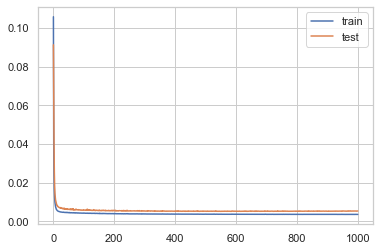

In [37]:
# plot history
from matplotlib import pyplot
pyplot.plot(RNN_classifier.history['loss'], label='train')
pyplot.plot(RNN_classifier.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

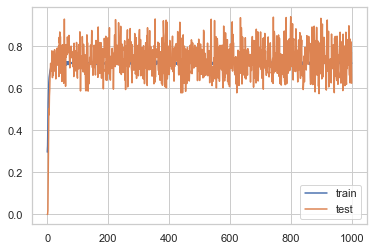

In [38]:
# plot history
from matplotlib import pyplot
pyplot.plot(RNN_classifier.history['acc'], label='train')
pyplot.plot(RNN_classifier.history['val_acc'], label='test')
pyplot.legend()
pyplot.show()

In [39]:
from numpy import concatenate
Y_Pred = model.predict(test_X)
Y_Pred.shape



(1334, 11)

In [40]:
test_X = test_X.reshape(test_X.shape[0], test_X.shape[2])
test_X.shape

(1334, 18)

In [41]:
inv_Y_Pred = concatenate((scaler_x.inverse_transform(test_X), scaler_y.inverse_transform(Y_Pred)),axis=1)
inv_y = concatenate((scaler_x.inverse_transform(test_X),scaler_y.inverse_transform(test_y)), axis=1)

In [42]:
# calculate RMSE
from math import sqrt
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(inv_y[0], inv_Y_Pred[0]))
print('Test RMSE (Prediction): %.3f' % rmse)

Test RMSE (Prediction): 2822.107


In [43]:
indexer=10
transformed_id=[''.join(list(map(str,list(map(int,list(scaler_x.inverse_transform(test_X)[indexer][:-10]))))))]
week_number=[scaler_x.inverse_transform(test_X)[indexer][-10]]
amount=[scaler_x.inverse_transform(test_X)[indexer][-9]]
total_sum=[scaler_x.inverse_transform(test_X)[indexer][-8]]
age=[scaler_x.inverse_transform(test_X)[indexer][-7]]
pin=[scaler_x.inverse_transform(test_X)[indexer][-6]]
unit_price=[scaler_x.inverse_transform(test_X)[indexer][-5]]
log_unit_price=[scaler_x.inverse_transform(test_X)[indexer][-4]]

In [44]:
prediction=list(scaler_y.inverse_transform(Y_Pred)[:, -3:][indexer])

In [45]:
#Prediction
output=pd.DataFrame((transformed_id+week_number+amount+total_sum+pin+age+unit_price+log_unit_price)).T.copy()
output.columns=['Predicted_cust_id','Week_number','Amount','Total_sum','Age_group','Pin_code','Unit_price','Log_unit_price']
output

,Predicted_cust_id,Week_number,Amount,Total_sum,Age_group,Pin_code,Unit_price,Log_unit_price
0,00020220,1.0,29.0,1444.0,6.0,5.0,1388.0,101.706


In [46]:
# Training
outputID=output['Predicted_cust_id'][0]
feature_df=X_set_df['customer_id']==outputID
X_set_df[feature_df][['customer_id','frequency','recency','monetary']]

,customer_id,frequency,recency,monetary
10,00020220,2,-2,4023.0


In [47]:
# true value
feature_df=y_set_df['customer_id']==outputID
y_set_df[feature_df][['customer_id','frequency','recency','monetary']]

,customer_id,frequency,recency,monetary
10,00020220,17,-13,22605.0
